In [15]:
import keras
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import ccxt
from sqlalchemy import create_engine
import matplotlib
from datetime import datetime, timedelta

with open("../api(JKBOT).txt") as f:
    lines = f.readlines()
    api_key = lines[0].strip()
    secret = lines[1].strip()

binance = ccxt.binance(config={
    'apiKey': api_key, #"XTpKrQGSk3GhXzqiEV4OfwGJzmTVcLh8dKGwHo4aQBH4p0mOqPDpIsxdh95tjGVf",
    'secret': secret, #"A0eqZGEWHsyL3NMM6WuDrucIanr7A2YZAnrwXVPhXpf2WGauIANwa5zsoNeNt0hs",
    'enableRateLimit' : True,
    'options': {
        'defaultType': 'future'
    }
})

jongmok= []

markets = binance.load_markets()
for market in markets.keys():
    if market.endswith("/USDT"):
        jongmok.append(market[:-5].lower())


def md_connect(user, password, db, host, port=3306):
    url = 'mysql+pymysql://{}:{}@{}:{}/{}'.format(user, password, host, port, db)
    engine = create_engine(url).connect()
    return engine

engine = md_connect('root', '1234', 'price_1d', 'localhost')


In [16]:
account = [] # 계좌 정보
diary = [] # 매매일지


window = 28
away = 7

start_date = ''
end_date = ''

tot_data = {}
engine = md_connect('root', '1234', 'price_1d', 'localhost')
for sym in jongmok[:100]:
    data = pd.read_sql(sym, engine, index_col='datetime') # 데이터 가져오기
    tot_data[sym] = data

##to_sql ind

In [3]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.LSTM(30, activation='relu', input_shape=(window, 4), dropout=0.3))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.load_weights('1d_28_7_(30).h5')

engine = md_connect('root', '1234', 'ind_test', 'localhost')


for key in jongmok[:80]:
    data = tot_data[key]
    x_data = tot_data[key][['open', 'high', 'low', 'close']]
    y_data = tot_data[key][['close']]

    x_input = []
    y_input = []

    ## 전처리
    for i in range(len(data)-window-away+1): #len(data)-window
        mean = x_data[i:i+window].mean()
        std = x_data[i:i+window].std()
        x = (x_data[i:i+window] - mean) / std
        x_input.append(x)
    #
    ## ind 지표 생성
    x_input = np.array(x_input)
    predict_data = model.predict(x_input).tolist()

    ## 수익률 생성
    data['rate'] = data['close'].pct_change(periods=away).shift(-away)


    predict = []
    for i in range(len(predict_data)):
        predict.append(predict_data[i][0])
    data = data[window-1:-away]
    data = data.copy()
    ##ind 지표 결합
    data['ind'] = predict
    print(len(data))

    data['sym'] = key

    data = data[['sym', 'open', 'high', 'low', 'close', 'rate', 'ind']]

    data.to_sql(key, engine, if_exists="replace", index=True)

39/39 [==============================] - 0s 2ms/step
1247
37/37 [==============================] - 0s 1ms/step
1167
36/36 [==============================] - 0s 1ms/step
1145
36/36 [==============================] - 0s 1ms/step
1127
36/36 [==============================] - 0s 1ms/step
1125
36/36 [==============================] - 0s 1ms/step
1124
35/35 [==============================] - 0s 1ms/step
1118
35/35 [==============================] - 0s 1ms/step
1117
35/35 [==============================] - 0s 1ms/step
1116
35/35 [==============================] - 0s 1ms/step
1113
35/35 [==============================] - 0s 1ms/step
1102
35/35 [==============================] - 0s 1ms/step
1099
35/35 [==============================] - 0s 1ms/step
1098
35/35 [==============================] - 0s 1ms/step
1097
35/35 [==============================] - 0s 1ms/step
1096
35/35 [==============================] - 0s 1ms/step
1092
35/35 [==============================] - 0s 1ms/step
1095
35/35 [=======

In [4]:
engine = md_connect('root', '1234', 'ind_test', 'localhost')
for sym in jongmok[:80]:
    data = pd.read_sql(sym, engine, index_col='datetime') # 데이터 가져오기
    tot_data[sym] = data

# 변수 설정
ind_data = []
for key in jongmok[:80]:
    ind_data.append(tot_data[key][['sym', 'close', 'rate', 'ind']])

ind_data = pd.concat(ind_data)


def select_rate(long_std, short_std, start_date=0, end_date=0, fee=0):
    df = ind_data[(ind_data['ind'] > long_std) | (ind_data['ind'] < short_std)].sort_index()
    condition = df['ind'] > 0.5
    df = df.assign(position=condition.map({True:1, False:-1}))
    df['profit'] = df['position'] * df['rate'] -(2 * fee)

    if start_date != 0:
        if end_date != 0:
            df = df.loc[start_date:end_date]
        else:
            df = df.loc[start_date:]
    else:
        if end_date !=0:
            df = df.loc[:end_date]


    df['count_sum'] = df.groupby('datetime').count()['sym'].rolling(window=28, min_periods=1).sum()
    df['tot_profit'] = df['profit'].cumsum()

    return df
log_column = ['시작', '끝', '거래기간', '매수조건', '매도조건', '거래 횟수', '승률', '승수', '패수', '평균보유량', '평균수익률', '총수익률']
log_df = pd.DataFrame(columns = log_column)
import matplotlib.pyplot as plt

In [32]:
test_df = ind_data[:200]

In [33]:
condition = test_df['ind'] > 0.7

In [35]:
matching_rows = test_df[condition].index.tolist()

In [43]:
rows_to_keep = []
chart_df = {}
for date in matching_rows:
    start_date = date - pd.Timedelta(days=14)
    end_date = date + pd.Timedelta(days=7)
    chart_df[date] = test_df.loc[start_date:end_date]


In [48]:
for key in chart_df:
    print(chart_df[key])

            sym     close      rate       ind
datetime                                     
2019-09-21  btc   9983.33 -0.179094  0.831631
2019-09-22  btc  10023.04 -0.197653  0.312380
2019-09-23  btc   9701.96 -0.145962  0.634735
2019-09-24  btc   8645.61 -0.041132  0.603672
2019-09-25  btc   8430.07 -0.009244  0.509726
2019-09-26  btc   8060.15  0.019866  0.554323
2019-09-27  btc   8176.52 -0.005621  0.684707
2019-09-28  btc   8195.38 -0.008937  0.625148
            sym     close      rate       ind
datetime                                     
2019-09-22  btc  10023.04 -0.197653  0.312380
2019-09-23  btc   9701.96 -0.145962  0.634735
2019-09-24  btc   8645.61 -0.041132  0.603672
2019-09-25  btc   8430.07 -0.009244  0.509726
2019-09-26  btc   8060.15  0.019866  0.554323
2019-09-27  btc   8176.52 -0.005621  0.684707
2019-09-28  btc   8195.38 -0.008937  0.625148
2019-09-29  btc   8041.96 -0.023523  0.645267
2019-09-30  btc   8285.84 -0.011943  0.587037
2019-10-01  btc   8290.00 -0.01476

In [17]:
df = ind_data.loc['2023-03-01':'2023-03-10']

In [13]:
df

,sym,close,rate,ind
datetime,,,,
2023-03-01,btc,23619.80000,-0.081474,0.776822
2023-03-02,btc,23457.10000,-0.132531,0.807428
2023-03-03,btc,22342.80000,-0.098578,0.792801
2023-03-04,btc,22335.70000,-0.104631,0.806607
2023-03-01,eth,1664.46000,-0.079690,0.660236
...,...,...,...,...
2023-03-04,chz,0.12245,-0.131319,0.783993
2023-03-01,sand,0.70510,-0.193590,0.253922
2023-03-02,sand,0.68940,-0.225994,0.187346


In [18]:
df = df[(df['ind'] > 0.8) | (df['ind'] < 0.2)].sort_index()

In [19]:
df

,sym,close,rate,ind
datetime,,,,
2023-03-01,lrc,0.3642,-0.182317,0.045207
2023-03-01,zec,44.3500,-0.195941,0.194076
2023-03-01,yfi,10354.0000,-0.215665,0.830035
2023-03-01,atom,12.7690,-0.142298,0.826392
2023-03-01,sxp,0.3284,-0.214068,0.031788
2023-03-02,btc,23457.1000,-0.132531,0.807428
2023-03-02,ocean,0.4030,-0.227543,0.829086
2023-03-02,lrc,0.3616,-0.244469,0.087275
2023-03-02,flm,0.1082,-0.234750,0.156231


In [23]:
start_date = '2023-03-01'
end_date = '2023-3-10'
long_std = 0.8
short_std = 0.2
start_date = datetime.strptime(start_date, '%Y-%m-%d')
end_date =  datetime.strptime(end_date, '%Y-%m-%d')

df = select_rate(long_std, short_std, start_date, end_date, 0.0004)

win_cnt = (df['profit'] > 0).sum()
lose_cnt = (df['profit'] < 0).sum()

day = end_date - start_date
day.days

# log.append([len(df), day.days, win_cnt / len(df), win_cnt, lose_cnt, df['count_sum'].mean(), df['profit'].mean(), df['profit'].sum()])
log = {'시작' : start_date, '끝' : end_date, '매수조건' : long_std, '매도조건' : short_std, '거래 횟수' : len(df), '거래기간' : day.days, '승률' : win_cnt / len(df), '승수' : win_cnt, '패수' : lose_cnt, '평균보유량' : df['count_sum'].mean(), '평균수익률' : df['profit'].mean(), '총수익률' : df['profit'].sum()}
log_df = log_df.append(log, ignore_index=True)

log_df

C:\Users\tomkj\AppData\Local\Temp\ipykernel_24284\2611005693.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append(log, ignore_index=True)


,시작,끝,거래기간,매수조건,매도조건,거래 횟수,승률,승수,패수,평균보유량,평균수익률,총수익률
0,2021-06-01,2022-12-31,578,0.8,0.3,15068,0.824263,12420,2648,786.621516,0.097177,1464.261833
1,2023-03-01,2023-03-10,9,0.8,0.3,87,0.735632,64,23,55.793103,0.076580,6.662477
2,2023-03-01,2023-03-10,9,0.8,0.2,54,0.574074,31,23,35.462963,0.024871,1.343017
3,2023-03-01,2023-03-10,9,0.9,0.1,14,0.714286,10,4,8.928571,0.091998,1.287973
4,2023-03-01,2023-03-10,9,0.9,0.1,14,0.714286,10,4,8.928571,0.091998,1.287973
5,2023-03-01,2023-03-10,9,0.8,0.2,54,0.574074,31,23,35.462963,0.024871,1.343017


In [24]:
long_std = 0.9
short_std = 0.1
select_rate(long_std, short_std, start_date, end_date, 0.0004)

,sym,close,rate,ind,position,profit,count_sum,tot_profit
datetime,,,,,,,,
2023-03-01,lrc,0.3642,-0.182317,0.045207,-1,0.181517,2.0,0.181517
2023-03-01,sxp,0.3284,-0.214068,0.031788,-1,0.213268,2.0,0.394786
2023-03-02,ftm,0.4456,-0.248429,0.035301,-1,0.247629,5.0,0.642415
2023-03-02,lrc,0.3616,-0.244469,0.087275,-1,0.243669,5.0,0.886084
2023-03-02,sxp,0.3182,-0.245757,0.053875,-1,0.244957,5.0,1.131041
2023-03-03,sol,21.4040,-0.152028,0.057919,-1,0.151228,9.0,1.282269
2023-03-03,atom,12.0060,-0.073130,0.952895,1,-0.073930,9.0,1.208339
2023-03-03,sxp,0.2931,-0.177414,0.075036,-1,0.176614,9.0,1.384953
2023-03-03,ftm,0.4263,-0.205020,0.074993,-1,0.204220,9.0,1.589172


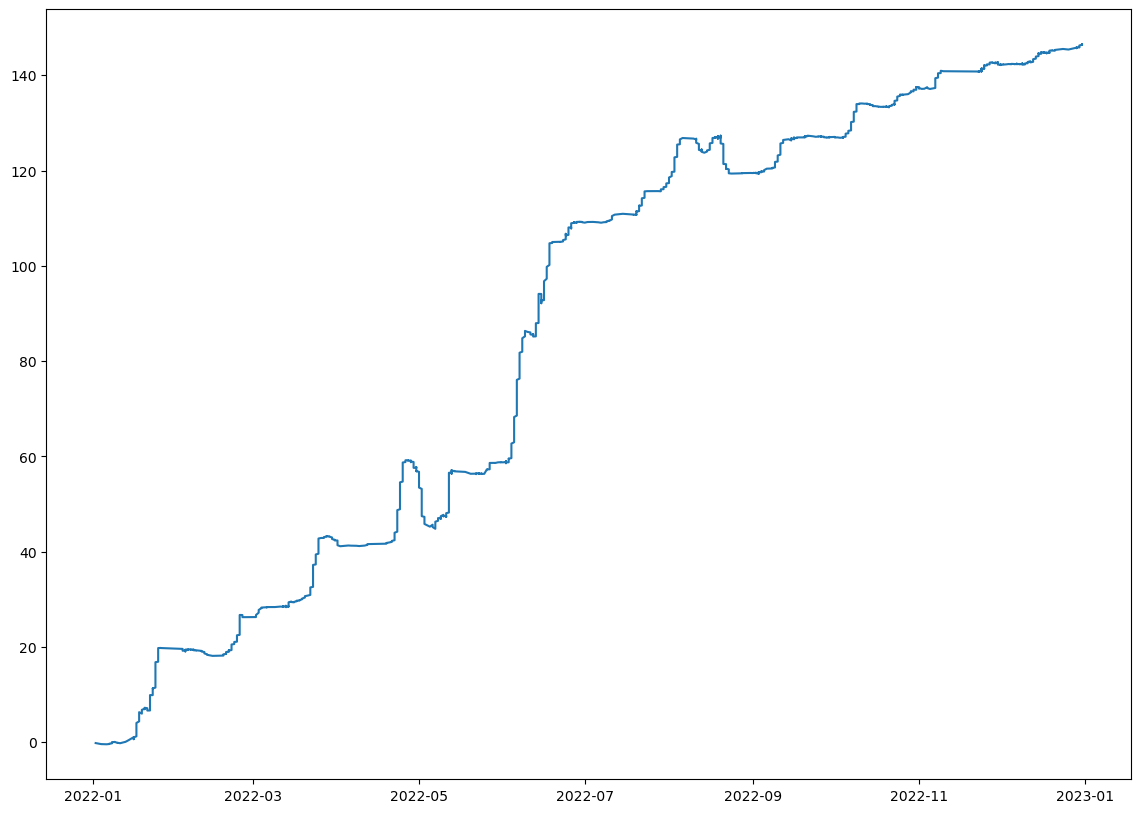

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(1, 1, 1)
# ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(df['tot_profit'], label='close')
# ax2.plot(result[3]['tot_profit'], label='tot_profit')
plt.show()

input 날짜, 종목

In [114]:
idea = ind_data[['sym', 'close', 'ind']]
idea = idea[['close', 'ind']]
idea.to_excel('graph.xlsx')